In [9]:
import mesa
import numpy as np
import skfuzzy.control as ctrl

In [10]:
# Sparse universe makes calculations faster, without sacrifice accuracy.
# Only the critical points are included here; making it higher resolution is
# unnecessary.
universe = np.linspace(-2, 2, 5)

# Create the three fuzzy variables - two inputs, one output
error = ctrl.Antecedent(universe, 'error')
delta = ctrl.Antecedent(universe, 'delta')
output = ctrl.Consequent(universe, 'output')

# Here we use the convenience `automf` to populate the fuzzy variables with
# terms. The optional kwarg `names=` lets us specify the names of our Terms.
names = ['nb', 'ns', 'ze', 'ps', 'pb']
error.automf(names=names)
delta.automf(names=names)
output.automf(names=names)

In [11]:
rule0 = ctrl.Rule(antecedent=((error['nb'] & delta['nb']) |
                              (error['ns'] & delta['nb']) |
                              (error['nb'] & delta['ns'])),
                  consequent=output['nb'], label='rule nb')

rule1 = ctrl.Rule(antecedent=((error['nb'] & delta['ze']) |
                              (error['nb'] & delta['ps']) |
                              (error['ns'] & delta['ns']) |
                              (error['ns'] & delta['ze']) |
                              (error['ze'] & delta['ns']) |
                              (error['ze'] & delta['nb']) |
                              (error['ps'] & delta['nb'])),
                  consequent=output['ns'], label='rule ns')

rule2 = ctrl.Rule(antecedent=((error['nb'] & delta['pb']) |
                              (error['ns'] & delta['ps']) |
                              (error['ze'] & delta['ze']) |
                              (error['ps'] & delta['ns']) |
                              (error['pb'] & delta['nb'])),
                  consequent=output['ze'], label='rule ze')

rule3 = ctrl.Rule(antecedent=((error['ns'] & delta['pb']) |
                              (error['ze'] & delta['pb']) |
                              (error['ze'] & delta['ps']) |
                              (error['ps'] & delta['ps']) |
                              (error['ps'] & delta['ze']) |
                              (error['pb'] & delta['ze']) |
                              (error['pb'] & delta['ns'])),
                  consequent=output['ps'], label='rule ps')

rule4 = ctrl.Rule(antecedent=((error['ps'] & delta['pb']) |
                              (error['pb'] & delta['pb']) |
                              (error['pb'] & delta['ps'])),
                  consequent=output['pb'], label='rule pb')

In [12]:
system = ctrl.ControlSystem(rules=[rule0, rule1, rule2, rule3, rule4])

# Later we intend to run this system with a 21*21 set of inputs, so we allow
# that many plus one unique runs before results are flushed.
# Subsequent runs would return in 1/8 the time!
sim = ctrl.ControlSystemSimulation(system, flush_after_run=21 * 21 + 1)

In [13]:
# We can simulate at higher resolution with full accuracy
upsampled = np.linspace(-2, 2, 21)
x, y = np.meshgrid(upsampled, upsampled)
z = np.zeros_like(x)

# Loop through the system 21*21 times to collect the control surface
for i in range(21):
    for j in range(21):
        sim.input['error'] = x[i, j]
        sim.input['delta'] = y[i, j]
        sim.compute()
        z[i, j] = sim.output['output']


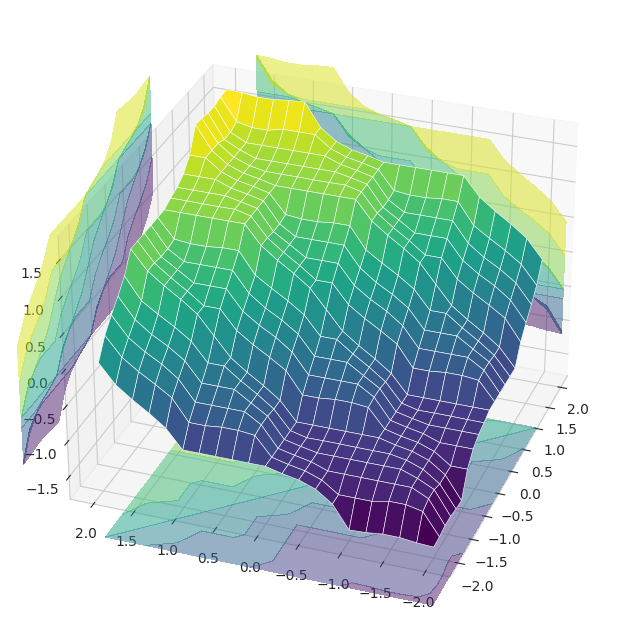

In [14]:

# Plot the result in pretty 3D with alpha blending
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0.4, antialiased=True)

cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

ax.view_init(30, 200)